In [45]:
from imu_dataset import IMUDataset
from model import IMUModelBig, IMUModelSmall
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.transforms as transforms
from pathlib import Path

In [46]:
VERSION = 'v1'
DATASET_PATH = "/Users/francescore/Desktop/dataset"
EXPORT_PATH = Path(f"model_{VERSION}")
TRAIN_VALID_SPLIT = 0.8
DEVICE = torch.device("cpu")
BATCH_SIZE = 32
EPOCHS = 50

In [47]:
input_transform = None #transforms.Normalize(...)

In [48]:
dataset = IMUDataset(base_path=DATASET_PATH, transform=input_transform)

train_set_size = int(len(dataset) * TRAIN_VALID_SPLIT)
valid_set_size = len(dataset) - train_set_size

train_dataset, valid_dataset = random_split(dataset, [train_set_size, valid_set_size])

len(train_dataset), len(valid_dataset)

(19, 5)

In [49]:
def show_sample(sample, label):
    sample = sample.squeeze(0)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(IMUDataset.IDX_TO_CLASS[label], fontsize=16)
    axs[0].set_title("Accelerometer")
    axs[0].plot(sample[:, 0], label="x")
    axs[0].plot(sample[:, 1], label="y")
    axs[0].plot(sample[:, 2], label="z")
    axs[0].legend()
    axs[1].set_title("Gyroscope")
    axs[1].plot(sample[:, 3], label="x")
    axs[1].plot(sample[:, 4], label="y")
    axs[1].plot(sample[:, 5], label="z")
    axs[1].legend()
    plt.show()

In [50]:
def predict(model, tensor):
    tensor.to(DEVICE)
    model.to(DEVICE)

    model.eval()
    with torch.no_grad():
        start_time = time.time()
        output = model(tensor)
        ps = torch.exp(output)

        prob, idx = torch.max(ps, 1) # dim 0 is batch, dim 1 is probability distribution
        
        idx = idx[0].item() # item 0 of the batch
        prob = prob[0].item() # item 0 of the batch

        return IMUDataset.IDX_TO_CLASS[idx], prob, time.time() - start_time

In [51]:
def export(model, stats):
    EXPORT_PATH.mkdir(parents=True, exist_ok=True)

    # pytorch jit
    torch.jit.save(torch.jit.script(model), EXPORT_PATH / f"model_{VERSION}.pt")

    # onnx
    torch.onnx.export(model.cpu(),
                    dataset[0][0].to('cpu').unsqueeze(0), # dummy input
                    EXPORT_PATH / f"model_{VERSION}.onnx",
                    input_names = ['input'],
                    output_names = ['output'],
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}}) 

    # save stats
    with open(EXPORT_PATH / f"stats_{VERSION}.txt", "w") as f:
        f.write(stats)
    
    model.to(DEVICE)

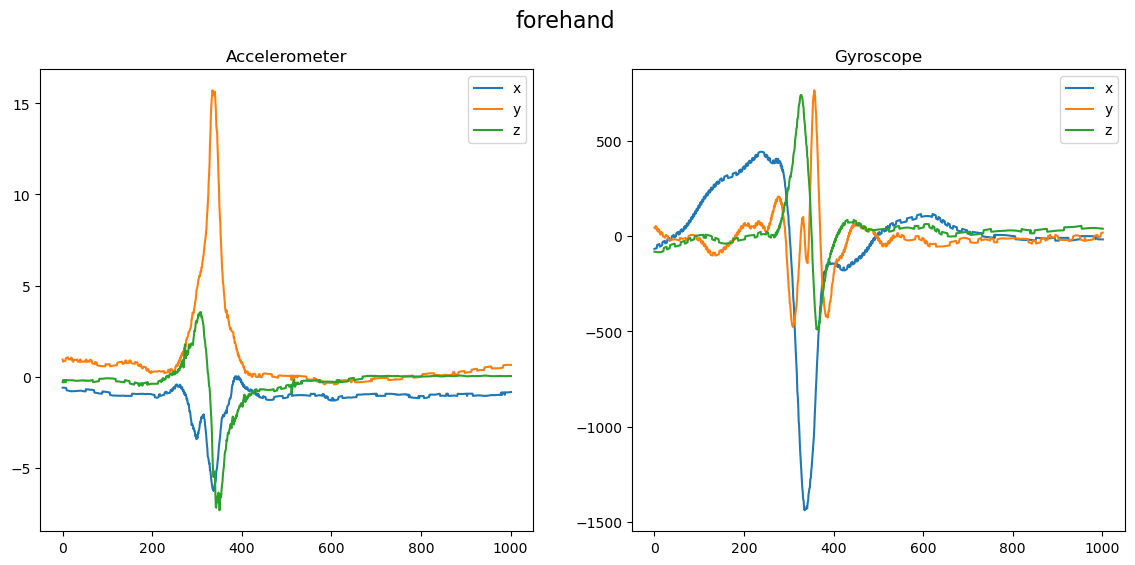

In [52]:
show_sample(*dataset[5])

In [53]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [54]:
model = IMUModelBig()
model = model.to(DEVICE)

In [55]:
loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Epoch: 000 | Train: 1.4171 (26.3158%) | Test: 1.4086 (20.0000%) | Time: 2.5144s
Epoch: 001 | Train: 1.2329 (42.1053%) | Test: 1.4033 (20.0000%) | Time: 2.4606s
Epoch: 002 | Train: 1.1020 (57.8947%) | Test: 1.3840 (40.0000%) | Time: 2.5603s
Epoch: 003 | Train: 1.0395 (73.6842%) | Test: 1.3626 (20.0000%) | Time: 2.5419s
Epoch: 004 | Train: 0.9729 (68.4211%) | Test: 1.3399 (20.0000%) | Time: 2.5512s
📍 Epoch: 005 | Train: 0.8253 (84.2105%) | Test: 1.3157 (60.0000%) | Time: 2.5000s
📍 Epoch: 006 | Train: 0.7810 (89.4737%) | Test: 1.2939 (80.0000%) | Time: 2.4913s
Epoch: 007 | Train: 0.7072 (100.0000%) | Test: 1.2741 (60.0000%) | Time: 2.4744s
Epoch: 008 | Train: 0.6386 (94.7368%) | Test: 1.2568 (80.0000%) | Time: 2.4996s
Epoch: 009 | Train: 0.5522 (100.0000%) | Test: 1.2450 (80.0000%) | Time: 2.5110s
Epoch: 010 | Train: 0.5106 (94.7368%) | Test: 1.2292 (60.0000%) | Time: 2.4685s
Epoch: 011 | Train: 0.4583 (94.7368%) | Test: 1.2060 (60.0000%) | Time: 2.4313s
Epoch: 012 | Train: 0.3427 (100.00

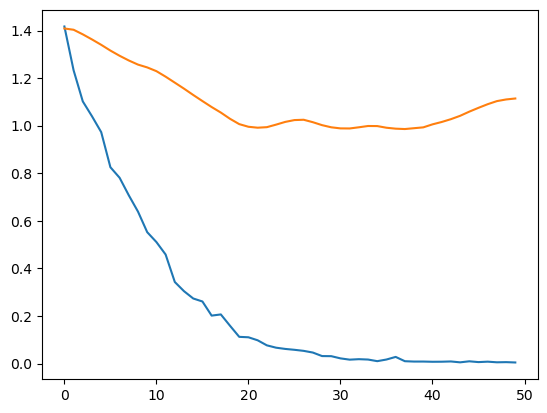

In [56]:
# training loop
history = []

best_train_acc = 0.5
best_valid_acc = 0.5

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Set to training mode
    model.train()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss_value = loss(outputs, labels)

        # Backpropagate the gradients
        loss_value.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss_value.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)


    # Validation - No gradient tracking needed
    with torch.no_grad():
    
        # Set to evaluation mode
        model.eval()
    
        for j, (inputs, labels) in enumerate(valid_data_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss_value = loss(outputs, labels)

            # Compute the total loss for the batch and add it valid_loss
            valid_loss += loss_value.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
                
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_dataset) 
        avg_train_acc = train_acc/float(len(train_dataset))
        
        # Find average valid loss and valid accuracy
        avg_valid_loss = valid_loss/len(valid_dataset) 
        avg_valid_acc = valid_acc/float(len(valid_dataset))
        
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        
        saved = ""
        if avg_train_acc > best_train_acc and avg_valid_acc > best_valid_acc:
            best_train_acc = avg_train_acc
            best_valid_acc = avg_valid_acc
            stats = f"Epoch: {epoch} | Train: {avg_train_loss:.4f} ({avg_train_acc*100:.4f}%) | Test: {avg_valid_loss:.4f} ({avg_valid_acc*100:.4f}%)"
            export(model, stats)
            saved = "📍 "
        
        print(f"{saved}Epoch: {epoch:03d} | Train: {avg_train_loss:.4f} ({avg_train_acc*100:.4f}%) | Test: {avg_valid_loss:.4f} ({avg_valid_acc*100:.4f}%) | Time: {epoch_end-epoch_start:.4f}s")


plt.plot([h[0] for h in history], label='train acc')
plt.plot([h[1] for h in history], label='valid acc')
plt.show()

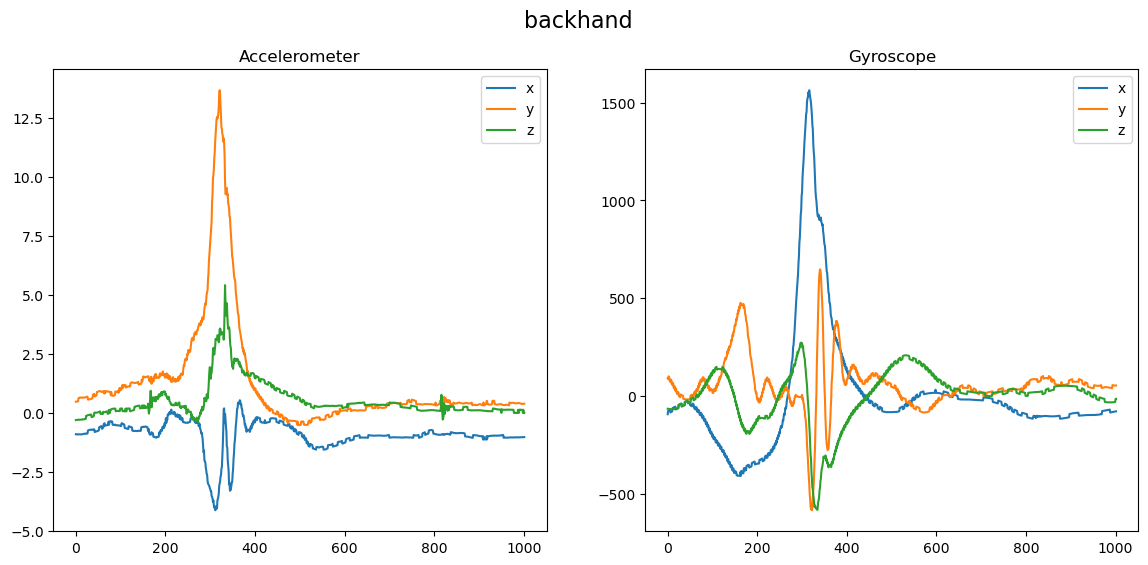

Predicted: backhand(99.9%), inference time: 11.64ms


In [58]:
# test prediction
sample = dataset[9]
tensor = sample[0].to('cpu').unsqueeze(0)
show_sample(*sample)

prediction, prob, inf_time = predict(model, tensor)
print(f"Predicted: {prediction}({prob*100:.1f}%), inference time: {inf_time*1000:.2f}ms")
